In [1]:
import pandas as pd
from pymatgen import Structure

from maml.describer import DistinctSiteProperty
from maml.model import ModelWithSklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline


/Users/chenchi/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

Using TensorFlow backend.


## Prepare the data

In [2]:
df = pd.read_csv("garnet.csv")
df = df[df['FormEnergyPerAtom'] > -5]

In [3]:
df.head()

,c,a,d,C-IonicRadius,C-ElectroNegativity,A-IonicRadius,A-ElectroNegativity,D-IonicRadius,D-ElectroNegativity,FormEnergyPerAtom
0,Gd3+,Sc3+,Al3+,1.075,1.20,0.885,1.36,0.675,1.61,-0.048480
1,Ca2+,Sc3+,Ti4+,1.140,1.00,0.885,1.36,0.745,1.54,-0.140997
2,Cd2+,Cr3+,Ge4+,1.090,1.69,0.755,1.66,0.670,2.01,-0.087724
3,Mg2+,Al3+,Ge4+,0.860,1.31,0.675,1.61,0.670,2.01,-0.037325
4,Cd2+,Tm3+,Ti4+,1.090,1.69,1.020,1.25,0.745,1.54,0.004684


In [4]:
parent = Structure.from_file("./Y3Al5O12.cif")
parent.add_oxidation_state_by_guess()
mapping = {'C': range(12), 'D': range(12, 24), "A": range(24, 32)}

In [5]:
## substitute the species to the parent structure

structures = []
targets = []
for i, j in df.iterrows():
    s = parent.copy()
    for k, indices in mapping.items():
        for index in indices:
            s.replace(index, j[k.lower()])
    structures.append(s)
    targets.append(j['FormEnergyPerAtom'])

## Model formation energy with DistinctSiteProperty describer and LinearRegression 

In [6]:
model = ModelWithSklearn(describer=DistinctSiteProperty(wyckoffs=['12c', '12d', '8a'], 
                                                       properties=['atomic_radius', 'X']), 
                        model=LinearRegression())

In [7]:
model.train(structures[:500], targets[:500])

In [8]:
preds = model.predict_objs(structures[500:])

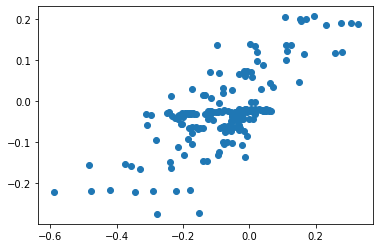

In [9]:
plt.plot(targets[500:], preds, 'o')

## Model formation energy with ElementProperty describer and Ridge regression 

In [10]:
from maml.describer import ElementProperty
from sklearn.linear_model import Ridge

model = ModelWithSklearn(describer=ElementProperty.from_preset('magpie'), 
                         model=Ridge(1e-2))

INFO:maml.describer._matminer_wrapper:Using matminer ElementProperty class


In [11]:
compositions = [i.composition for i in structures]

In [12]:
model.train(compositions[:500], targets[:500])

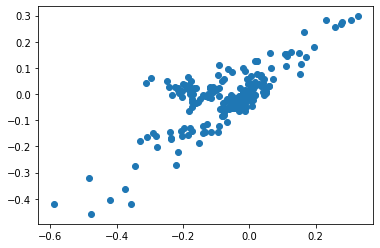

In [13]:
preds = model.predict_objs(compositions[500:])
plt.plot(targets[500:], preds, 'o')

## Model formation energy with DistinctSiteProperty describer and Multi-layer Perceptron

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from maml.model import ModelWithKeras


k_model = Sequential()
k_model.add(Dense(8, input_dim=6, activation='relu'))
k_model.add(Dense(1))
k_model.compile('adam', 'mse')

model = ModelWithKeras(describer=DistinctSiteProperty(wyckoffs=['12c', '12d', '8a'], 
                                                       properties=['atomic_radius', 'X']), 
                       model=k_model)

In [18]:
model.train(structures[:500], targets[:500], epochs=100)

Epoch 1/100
500/500 [==============================] - 0s 61us/step - loss: 0.0344
Epoch 2/100
500/500 [==============================] - 0s 97us/step - loss: 0.0308
Epoch 3/100
500/500 [==============================] - 0s 63us/step - loss: 0.0259
Epoch 4/100
500/500 [==============================] - 0s 64us/step - loss: 0.0221
Epoch 5/100
500/500 [==============================] - 0s 69us/step - loss: 0.0187
Epoch 6/100
500/500 [==============================] - 0s 85us/step - loss: 0.0157
Epoch 7/100
500/500 [==============================] - 0s 73us/step - loss: 0.0137
Epoch 8/100
500/500 [==============================] - 0s 96us/step - loss: 0.0123
Epoch 9/100
500/500 [==============================] - 0s 84us/step - loss: 0.0113
Epoch 10/100
500/500 [==============================] - 0s 57us/step - loss: 0.0108
Epoch 11/100
500/500 [==============================] - 0s 55us/step - loss: 0.0103
Epoch 12/100
500/500 [==============================] - 0s 80us/step - loss: 0.0099
E

500/500 [==============================] - 0s 114us/step - loss: 0.0068
Epoch 99/100
500/500 [==============================] - 0s 121us/step - loss: 0.0068
Epoch 100/100
500/500 [==============================] - 0s 64us/step - loss: 0.0067


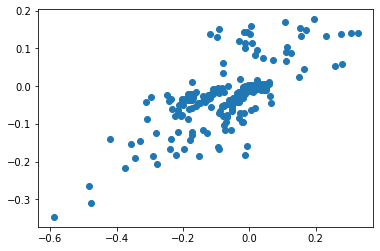

In [20]:
preds = model.predict_objs(structures[500:])
plt.plot(targets[500:], preds, 'o')